In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax

import icomo

In [22]:
def model(t, y, args):
    cm = icomo.CompModel(y)
    
    m = args["m_max"] - args["m_max"]/args["H_thres"]*args["m_eps"]*\
        jax.numpy.log( 1+jax.numpy.exp( (args["H_thres"]- args["H"])/args["m_eps"] ))
    lambda_STI = args["lambda_0"]\
               + args["c"]*(1-m)*args["beta_HIV"]*args["H"]*(1-args["P_HIV"])\
               + args["lambda_P"]*args["P_HIV"]
        
    # basic STI dynamics
    cm.flow("S_STI", "I_STI", (1-m*(1-args["P_HIV"]))*args["beta_STI"]*y["I_STI"])
    cm.flow("I_STI", "S_STI", args["gamma_STI"])
    cm.flow("I_STI", "T_STI", lambda_STI)
    cm.flow("T_STI", "S_STI", args["gammaT_STI"])
    # vital dynamics
    cm.flow("I_STI", "S_STI", args["mu"])
    cm.flow("T_STI", "S_STI", args["mu"])
    
    
#    cm.view_graph()
    return cm.dy

args = {
    "beta_HIV": 0.6341/360.,
    "beta_STI": 0.0016              *5.,
    "mu": 1./45./360.,
    "gamma_STI": 1./1.32/360.,
    "gammaT_STI": 1./7.,
    "lambda_0": (1.-0.7)/11.        /360.,
    "lambda_P": 12./9./360.,
    ####
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.,
    "H_tau": 20.,
    "c": 1.,
    "H": 0.,
    "P_HIV": 0.,
}

y0 = {
    "S_STI": 0.99,
    "I_STI": 0.01,
    "T_STI": 0.0,
}

In [23]:
ts = np.linspace(0,3600*5,3600)
integrator_object = icomo.ODEIntegrator(
    ts_out = ts,
    t_0 = min(ts),
    ts_solver = ts,
)

integrator = integrator_object.get_func(model)

In [24]:
Hs = np.linspace(0,0.1,11)
Ps = np.linspace(0,0.8,21)
res_I = np.zeros([len(Hs),len(Ps)])
res_T = np.zeros([len(Hs),len(Ps)])
res_I_inflow = np.zeros([len(Hs),len(Ps)])
res_T_inflow = np.zeros([len(Hs),len(Ps)])
check = np.zeros([len(Hs),len(Ps)])

for i,H in enumerate(Hs):
    for j,P in enumerate(Ps):
        args_mod = args.copy()
        args_mod["H"] = H
        args_mod["P_HIV"] = P
        output = integrator(y0=y0, constant_args=args_mod)
        m = args["m_max"] - args["m_max"]/args["H_thres"]*args["m_eps"]*\
            jax.numpy.log( 1+jax.numpy.exp( (args["H_thres"]- args["H"])/args["m_eps"] ))
        lambda_STI = args["lambda_0"]\
               + args["c"]*(1-m)*args["beta_HIV"]*args["H"]*(1-args["P_HIV"])\
               + args["lambda_P"]*args["P_HIV"]
        res_I[i,j] = output["I_STI"][-1]
        res_T[i,j] = output["T_STI"][-1]
        res_I_inflow[i,j] = (1-m*(1-args["P_HIV"]))*args["beta_STI"]*output["I_STI"][-1]*output["S_STI"][-1]
        res_T_inflow[i,j] = lambda_STI*output["I_STI"][-1]
        check[i,j] = abs(output["I_STI"][-1]-output["I_STI"][-101])\
                   + abs(output["T_STI"][-1]-output["T_STI"][-101])
print( check.max() )

0.001006692256145091


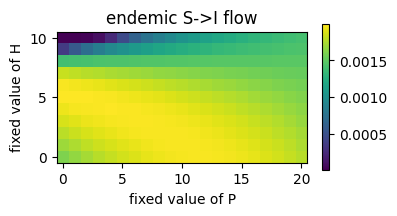

In [25]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_I_inflow, origin="lower")
plt.title("endemic S->I flow")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
#plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
#plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

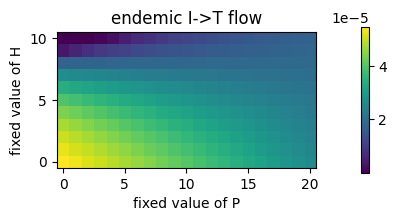

In [26]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_T_inflow, origin="lower")
plt.title("endemic I->T flow")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
#plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
#plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

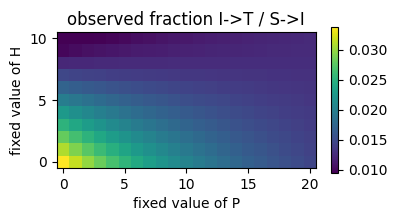

In [27]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_T_inflow/res_I_inflow, origin="lower")
plt.title("observed fraction I->T / S->I")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
#plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
#plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

In [8]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_I-res_T, origin="lower")
plt.title("observed fraction T/(T+I)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

NameError: name 'res_I' is not defined

<Figure size 400x300 with 0 Axes>

In [ ]:
check